# Artifact rejection

In [1]:
import yasa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.2)

# Load data
f = np.load('data_full_6hrs_100Hz_9channels.npz')
data= f['data']
chan = ['Fz', 'F3', 'F4', 'Cz', 'C3', 'C4', 'Pz', 'P3', 'P4']
sf = 100.
hypno = np.load('data_full_6hrs_100Hz_hypno.npz').get('hypno')
times = np.arange(data.size) / sf

print(data.shape)
print(chan)
print(np.round(data[:, 0:5], 3))

(9, 2161058)
['Fz', 'F3', 'F4', 'Cz', 'C3', 'C4', 'Pz', 'P3', 'P4']
[[20.963 30.527 45.829 29.15  31.751]
 [ 1.527 12.594 37.552 11.296 16.334]
 [15.797 22.307 39.922 25.657 27.094]
 [28.573 39.195 48.994 33.361 37.699]
 [-3.08   6.971 26.262  3.323  9.078]
 [16.896 26.385 40.966 21.833 24.456]
 [11.759 17.329 35.664 25.762 26.536]
 [ 4.069 10.635 35.882 18.311 18.958]
 [ 5.899 14.297 36.592 26.094 23.395]]


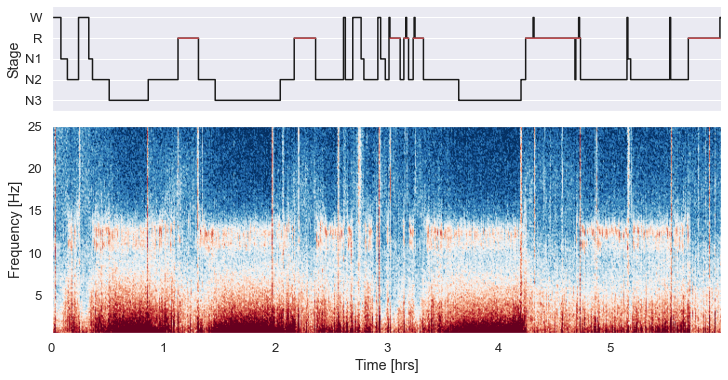

In [2]:
# Plot hypnogram and spectrogram on Fz
yasa.plot_spectrogram(data[0, :], sf, hypno);

***************

## 1. Artifact rejection without using the hypnogram

### 1.1. Covariance-based rejection

In [3]:
art, zscores = yasa.art_detect(data, sf, window=5, method='covar', threshold=3)
art.shape, zscores.shape

((4322,), (4322,))

In [4]:
# Art is an aray of 0 and 1, where 0 indicates a clean (or good epoch)  and 1 indicates an artifact epoch
print(art)
print(f'{art.sum()} / {art.size} epochs rejected.')

[False False False ...  True  True False]
61 / 4322 epochs rejected.


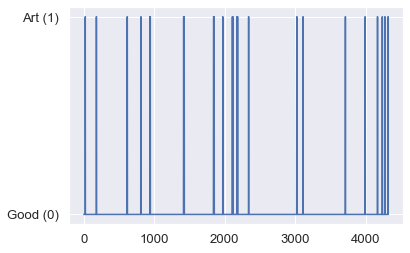

In [5]:
# Plot the artifact vector
plt.plot(art);
plt.yticks([0, 1], labels=['Good (0)', 'Art (1)']);

**Plot the distribution of z-scores**

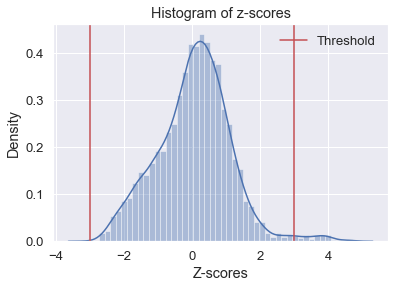

In [6]:
sns.distplot(zscores)
plt.title('Histogram of z-scores')
plt.xlabel('Z-scores')
plt.ylabel('Density')
plt.axvline(3, color='r', label='Threshold')
plt.axvline(-3, color='r')
plt.legend(frameon=False);

Given a threshold defined in the number of standard deviations from the mean, the proportion of samples that will be outside the range (e.g. rejected) is defined as $1 - \text{erf}\left ( \frac{z}{\sqrt{2}}\right )$. For more details, see https://en.wikipedia.org/wiki/Standard_deviation#Rules_for_normally_distributed_data

In [7]:
from scipy.special import erf
threshold = 3
perc_expected_rejected = (1 - erf(threshold / np.sqrt(2))) * 100
print(f'{perc_expected_rejected:.2f}% of all epochs are expected to be rejected.')

0.27% of all epochs are expected to be rejected.


In [8]:
# Actual
(art.sum() / art.size) * 100
print(f'{(art.sum() / art.size) * 100:.2f}% of all epochs were actually rejected.')

1.41% of all epochs were actually rejected.


**Merge the artifact vector with the hypnogram**

In [9]:
# The resolution of art is 5 seconds, so its sampling frequency is 1/5 (= 0.2 Hz)
sf_art = 1 / 5
art_up = yasa.hypno_upsample_to_data(art, sf_art, data, sf)
art_up.shape, hypno.shape

24-Mar-20 00:00:20 | WARNING | Hypnogram is SHORTER than data by 0.58 seconds. Padding hypnogram with last value to match data.size.


((2161058,), (2161058,))

Now that `hypno` and `art_up` have the same size, we can easily merge them. Below, we mark as artifact (code = -1) all the 5-seconds epochs that were automatically rejected:

In [10]:
# Add -1 to hypnogram where artifacts were detected
hypno_with_art = hypno.copy()
hypno_with_art[art_up] = -1

# Proportion of each stage in ``hypno_with_art``
pd.Series(hypno_with_art).value_counts(normalize=True)

 2    0.435843
 3    0.245285
 4    0.218615
 0    0.055633
 1    0.030510
-1    0.014113
dtype: float64

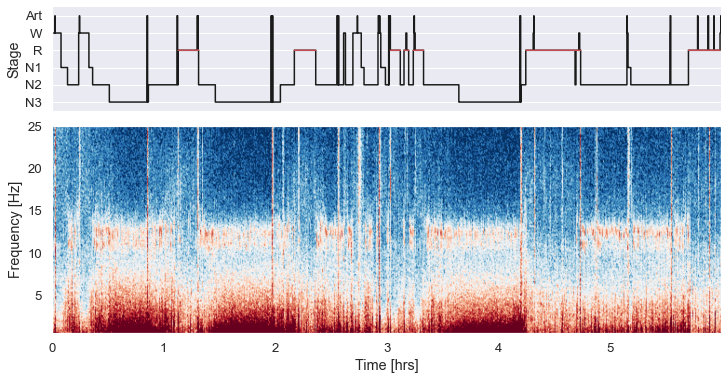

In [11]:
# Plot new hypnogram and spectrogram on Fz
yasa.plot_spectrogram(data[0, :], sf, hypno_with_art);

### 1.2. Standard-deviation based rejection

**To get more details, one can set the verbose level using logging**

In [12]:
import logging
logging.getLogger('yasa').setLevel(logging.INFO)
art_std, zscores_std = yasa.art_detect(data, sf, window=5, method='std', threshold=3)
art_std.shape, zscores_std.shape

24-Mar-20 00:00:25 | INFO | Number of channels in data = 9
24-Mar-20 00:00:25 | INFO | Number of samples in data = 2161058
24-Mar-20 00:00:25 | INFO | Sampling frequency = 100.00 Hz
24-Mar-20 00:00:25 | INFO | Data duration = 21610.58 seconds
24-Mar-20 00:00:25 | INFO | Number of epochs = 4322
24-Mar-20 00:00:25 | INFO | Artifact window = 5.00 seconds
24-Mar-20 00:00:25 | INFO | Method = std
24-Mar-20 00:00:25 | INFO | Threshold = 3.00 standard deviations
24-Mar-20 00:00:25 | INFO | TOTAL: 85 / 4322 epochs rejected (1.97%)


((4322,), (4322, 9))

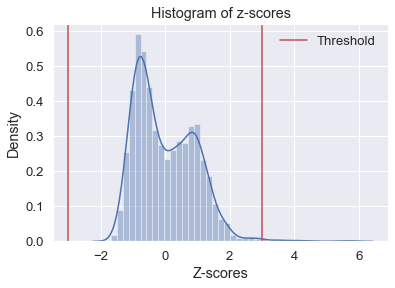

In [13]:
sns.distplot(zscores_std.mean(-1))
plt.title('Histogram of z-scores')
plt.xlabel('Z-scores')
plt.ylabel('Density')
plt.axvline(3, color='r', label='Threshold')
plt.axvline(-3, color='r')
plt.legend(frameon=False);

In [14]:
print(f'The correlation between the two methods is {np.corrcoef(art, art_std)[0, 1]:.2f}')

The correlation between the two methods is 0.84


***************

## 2. Artifact rejection with the hypnogram

### 2.1. Covariance-based rejection

In [15]:
art, zscores = yasa.art_detect(data, sf, window=5, hypno=hypno, include=(1, 2, 3, 4), 
                               method='covar', threshold=3)
art.shape, zscores.shape

24-Mar-20 00:00:25 | INFO | Number of unique values in hypno = 5
24-Mar-20 00:00:26 | INFO | Number of channels in data = 9
24-Mar-20 00:00:26 | INFO | Number of samples in data = 2161058
24-Mar-20 00:00:26 | INFO | Sampling frequency = 100.00 Hz
24-Mar-20 00:00:26 | INFO | Data duration = 21610.58 seconds
24-Mar-20 00:00:26 | INFO | Number of epochs = 4322
24-Mar-20 00:00:26 | INFO | Artifact window = 5.00 seconds
24-Mar-20 00:00:26 | INFO | Method = covar
24-Mar-20 00:00:26 | INFO | Threshold = 3.00 standard deviations
24-Mar-20 00:00:27 | INFO | Stage 1: 4 / 132 epochs rejected (3.03%)
24-Mar-20 00:00:31 | INFO | Stage 2: 17 / 1895 epochs rejected (0.90%)
24-Mar-20 00:00:34 | INFO | Stage 3: 19 / 1074 epochs rejected (1.77%)
24-Mar-20 00:00:37 | INFO | Stage 4: 53 / 960 epochs rejected (5.52%)
24-Mar-20 00:00:37 | INFO | TOTAL: 93 / 4322 epochs rejected (2.15%)


((4322,), (4322,))

24-Mar-20 00:00:37 | WARNING | Hypnogram is SHORTER than data by 0.58 seconds. Padding hypnogram with last value to match data.size.


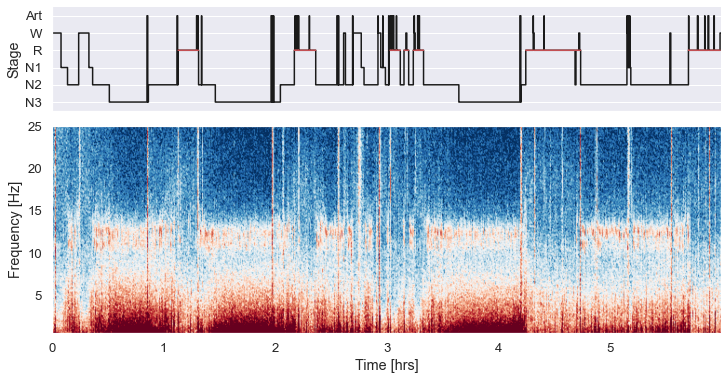

In [16]:
art_up = yasa.hypno_upsample_to_data(art, sf_art, data, sf)

# Add -1 to hypnogram where artifacts were detected
hypno_with_art = hypno.copy()
hypno_with_art[art_up] = -1

yasa.plot_spectrogram(data[0, :], sf, hypno_with_art);

### 1.2. Standard-deviation based rejection

In [17]:
art_std, zscores_std = yasa.art_detect(data, sf, window=5, hypno=hypno, include=(1, 2, 3, 4), 
                               method='std', threshold=3)

art_std.shape, zscores_std.shape

24-Mar-20 00:00:41 | INFO | Number of unique values in hypno = 5
24-Mar-20 00:00:41 | INFO | Number of channels in data = 9
24-Mar-20 00:00:41 | INFO | Number of samples in data = 2161058
24-Mar-20 00:00:41 | INFO | Sampling frequency = 100.00 Hz
24-Mar-20 00:00:41 | INFO | Data duration = 21610.58 seconds
24-Mar-20 00:00:41 | INFO | Number of epochs = 4322
24-Mar-20 00:00:41 | INFO | Artifact window = 5.00 seconds
24-Mar-20 00:00:41 | INFO | Method = std
24-Mar-20 00:00:41 | INFO | Threshold = 3.00 standard deviations
24-Mar-20 00:00:42 | INFO | Stage 1: 8 / 132 epochs rejected (6.06%)
24-Mar-20 00:00:42 | INFO | Stage 2: 26 / 1895 epochs rejected (1.37%)
24-Mar-20 00:00:42 | INFO | Stage 3: 19 / 1074 epochs rejected (1.77%)
24-Mar-20 00:00:42 | INFO | Stage 4: 44 / 960 epochs rejected (4.58%)
24-Mar-20 00:00:42 | INFO | TOTAL: 97 / 4322 epochs rejected (2.24%)


((4322,), (4322, 9))

24-Mar-20 00:00:42 | WARNING | Hypnogram is SHORTER than data by 0.58 seconds. Padding hypnogram with last value to match data.size.


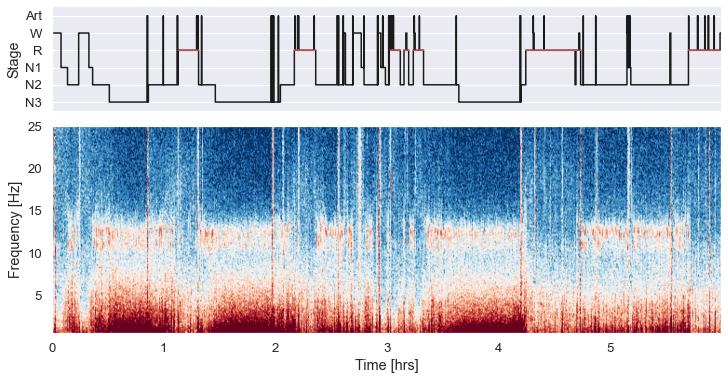

In [18]:
art_up = yasa.hypno_upsample_to_data(art_std, sf_art, data, sf)

# Add -1 to hypnogram where artifacts were detected
hypno_with_art = hypno.copy()
hypno_with_art[art_up] = -1

yasa.plot_spectrogram(data[0, :], sf, hypno_with_art);

In [19]:
print(f'The correlation between the two methods is {np.corrcoef(art, art_std)[0, 1]:.2f}')

The correlation between the two methods is 0.85
